In [ ]:
import pandas as pd
import string
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Importing Original dataset

In [63]:
df = pd.read_csv('dataset.csv', header=0)

Importing HuggingFace Test Dataset

In [68]:
test_df = pd.read_csv('new_dataset.csv', header=0)

In [77]:
df =df.drop(['adjective_count'], axis=1)

In [80]:
test_df = test_df[['generated', 'word_count', 'vocabulary_richness', 'gunning_fog',
       'smog_index', 'polarity', 'subjectivity', 'noun_count', 'verb_count',
       'adverb_count', 'noun_density', 'verb_density',
       'adjective_density', 'adverb_density', 'perplexity', 'ai_ratio']]

In [83]:
len(test_df)

15000

Cleaning up the data

In [84]:
df = df.dropna(subset=['perplexity'])

In [86]:
df = df[df['generated'] != 'generated']

In [87]:
df['generated'] = df['generated'].astype(int)

# Training with all features

In [88]:
X = df.drop('generated', axis=1)
y = df['generated']

In [89]:
Xt = test_df.drop('generated', axis=1)
yt = test_df['generated']

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [91]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])

In [92]:
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['linear'],
    'svm__gamma': [0.001, 0.01, 0.1, 1]
}

In [93]:
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

In [94]:
grid_search.fit(X_train, y_train)
print("\nBest Parameters:", grid_search.best_params_)


Best Parameters: {'svm__C': 10, 'svm__gamma': 0.001, 'svm__kernel': 'linear'}


Training metrics

In [95]:
train_predictions = grid_search.predict(X_train)
print(classification_report(y_train, train_predictions))
auc_roc = roc_auc_score(y_train, train_predictions)
print("AUC-ROC:", auc_roc)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3400
           1       0.97      0.97      0.97      2366

    accuracy                           0.97      5766
   macro avg       0.97      0.97      0.97      5766
weighted avg       0.97      0.97      0.97      5766

AUC-ROC: 0.972110163592064


Validation metrics

In [96]:
val_predictions = grid_search.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(classification_report(y_val, val_predictions))
auc_roc = roc_auc_score(y_val, val_predictions)
print("AUC-ROC:", auc_roc)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1134
           1       0.97      0.94      0.96       788

    accuracy                           0.97      1922
   macro avg       0.97      0.96      0.96      1922
weighted avg       0.97      0.97      0.97      1922

AUC-ROC: 0.9619938405894413


Test dataset Metrics

In [97]:
test_predictions = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(classification_report(y_test, test_predictions))
auc_roc = roc_auc_score(y_test, test_predictions)
print("AUC-ROC:", auc_roc)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1092
           1       0.97      0.95      0.96       830

    accuracy                           0.97      1922
   macro avg       0.97      0.97      0.97      1922
weighted avg       0.97      0.97      0.97      1922

AUC-ROC: 0.9664327640231255


Completely new dataset test metrics

In [98]:
test_predictions = grid_search.predict(Xt)
test_accuracy = accuracy_score(yt, test_predictions)
print(classification_report(yt, test_predictions))
auc_roc = roc_auc_score(yt, test_predictions)
print("AUC-ROC:", auc_roc)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7500
           1       0.97      0.99      0.98      7500

    accuracy                           0.98     15000
   macro avg       0.98      0.98      0.98     15000
weighted avg       0.98      0.98      0.98     15000

AUC-ROC: 0.9769333333333332


In [126]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(X, y, title, roc):
  fpr, tpr, thresholds = roc_curve(y, grid_search.predict_proba(X)[:, 1])
  roc_auc = auc(fpr, tpr)

  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) - '+title)
  plt.legend(loc="lower right")
  plt.show()

In [121]:
def plot_confusion_matrix(y, y_pred, title):
  cm = confusion_matrix(y, y_pred)

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
              xticklabels=['Predicted 0', 'Predicted 1'],
              yticklabels=['Actual 0', 'Actual 1'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix for " + title)
  plt.show()

# Training with 3 features

In [101]:
X = df[['perplexity', 'gunning_fog', 'smog_index']]
y = df['generated']

In [102]:
Xt = test_df[['perplexity', 'gunning_fog', 'smog_index']]
yt = test_df['generated']

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [104]:
grid_search.fit(X_train, y_train)
print("\nBest Parameters:", grid_search.best_params_)


Best Parameters: {'svm__C': 100, 'svm__gamma': 0.001, 'svm__kernel': 'linear'}


In [105]:
train_predictions = grid_search.predict(X_train)
print(classification_report(y_train, train_predictions))
auc_roc = roc_auc_score(y_train, train_predictions)
print("AUC-ROC:", auc_roc)

              precision    recall  f1-score   support

           0       0.88      0.91      0.90      3400
           1       0.87      0.82      0.84      2366

    accuracy                           0.87      5766
   macro avg       0.87      0.87      0.87      5766
weighted avg       0.87      0.87      0.87      5766

AUC-ROC: 0.866766570533539


In [106]:
val_predictions = grid_search.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(classification_report(y_val, val_predictions))
auc_roc = roc_auc_score(y_val, val_predictions)
print("AUC-ROC:", auc_roc)

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1134
           1       0.87      0.80      0.83       788

    accuracy                           0.87      1922
   macro avg       0.87      0.86      0.86      1922
weighted avg       0.87      0.87      0.87      1922

AUC-ROC: 0.8580526683318561


In [124]:
test_predictions = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(classification_report(y_test, test_predictions))
auc_roc = roc_auc_score(y_test, test_predictions)
print("AUC-ROC:", auc_roc)

              precision    recall  f1-score   support

           0       0.86      0.91      0.89      1092
           1       0.88      0.81      0.84       830

    accuracy                           0.87      1922
   macro avg       0.87      0.86      0.86      1922
weighted avg       0.87      0.87      0.87      1922

AUC-ROC: 0.8604296306103534


In [108]:
new_test_predictions = grid_search.predict(Xt)
test_accuracy = accuracy_score(yt, new_test_predictions)
print(classification_report(yt, new_test_predictions))
auc_roc = roc_auc_score(yt, new_test_predictions)
print("AUC-ROC:", auc_roc)

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      7500
           1       0.94      0.84      0.89      7500

    accuracy                           0.89     15000
   macro avg       0.90      0.89      0.89     15000
weighted avg       0.90      0.89      0.89     15000

AUC-ROC: 0.8930666666666667


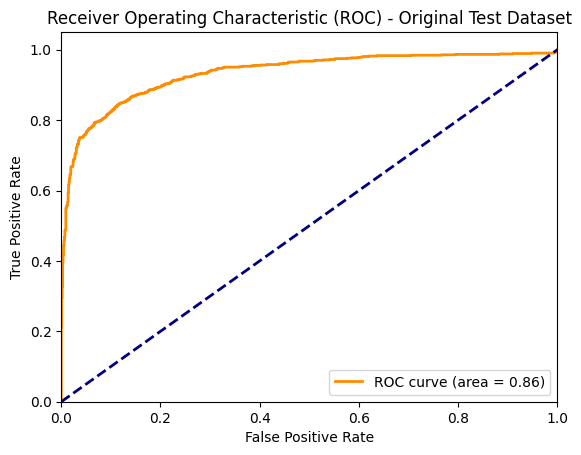

In [127]:
plot_roc_curve(X_test, y_test, "Original Test Dataset", auc_roc)

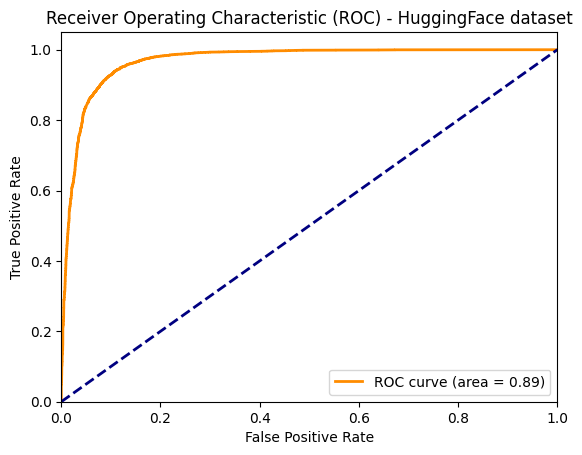

In [120]:
plot_roc_curve(Xt, yt,'HuggingFace dataset')

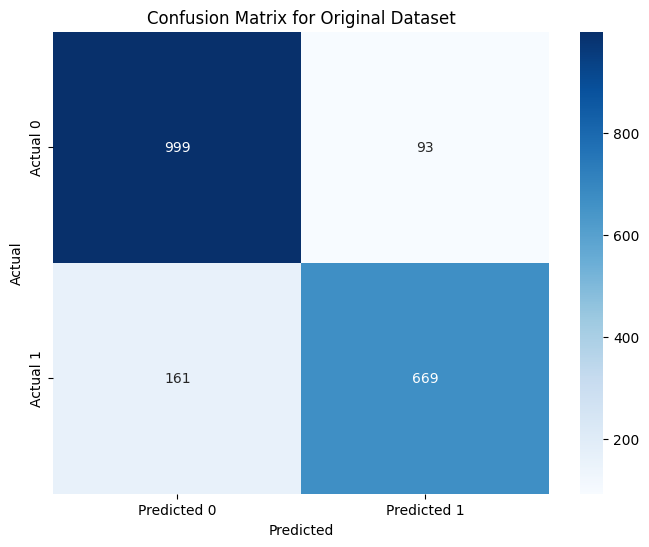

In [122]:
plot_confusion_matrix(y_test, test_predictions, "Original Dataset")

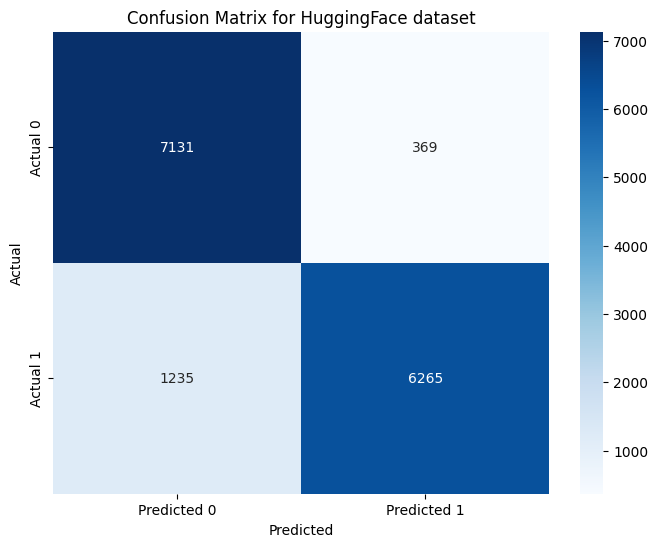

In [123]:
plot_confusion_matrix(yt, new_test_predictions,'HuggingFace dataset')